In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import random
from time import  time

In [ ]:
def load_data(file_path, offset):
    return np.frombuffer(open(file_path, 'rb').read(), np.uint8, offset=offset)

def reshape_images(data, reshape_dims):
    return data.reshape(reshape_dims)

imagesTrain = load_data("/content/train-images.idx3-ubyte", offset=16)
labelsTrain = load_data("/content/train-labels.idx1-ubyte", offset=8)
imagesTest = load_data("/content/t10k-images.idx3-ubyte", offset=16)
labelsTest = load_data("/content/t10k-labels.idx1-ubyte", offset=8)

w, h = 28, 28
reshape_dims = (-1, w, h)

imagesTrain = reshape_images(imagesTrain, reshape_dims)
imagesTest = reshape_images(imagesTest, reshape_dims)

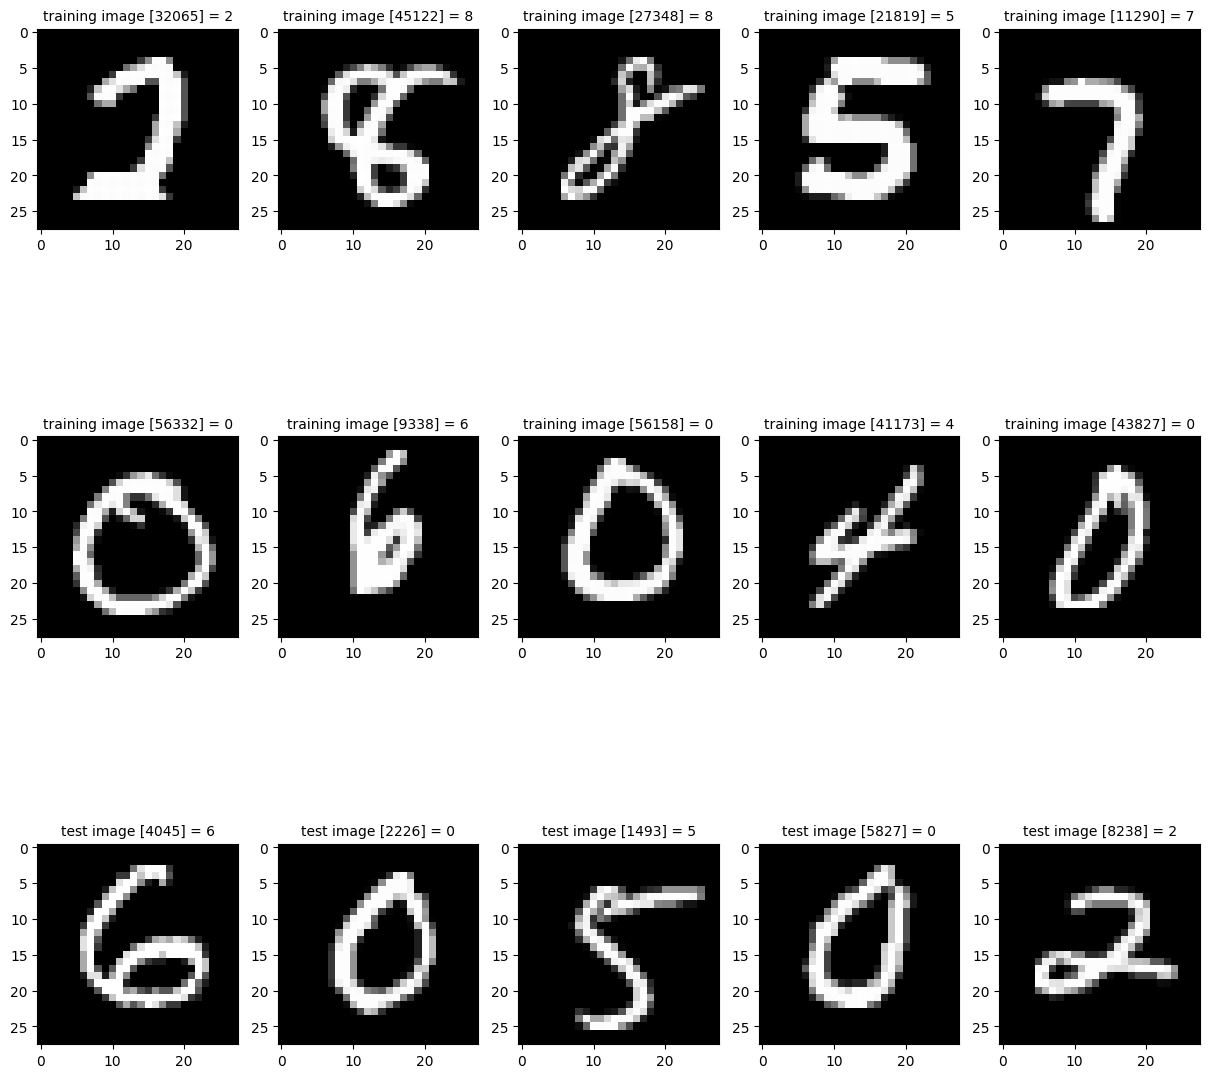

In [ ]:
def show_images(images, title_texts):
    cols = 5
    rows = -(-len(images) // cols)
    plt.figure(figsize=(15, 15))

    for index, (image, title_text) in enumerate(zip(images, title_texts), start=1):
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap='gray')
        if title_text:
            plt.title(title_text, fontsize=10)

def select_random_images(images, labels, count, prefix):
    return [
        (images[r], f'{prefix} image [{r}] = {labels[r]}')
        for r in random.sample(range(len(images)), count)
    ]

images_2_show, titles_2_show = zip(*select_random_images(imagesTrain, labelsTrain, 10, 'training'))
images_test, titles_test = zip(*select_random_images(imagesTest, labelsTest, 5, 'test'))

images_2_show += images_test
titles_2_show += titles_test

show_images(images_2_show, titles_2_show)

In [ ]:
print('Размерность тренировочных данных:', imagesTrain.shape)
print('Размерность тестовых данных:', imagesTest.shape)

Размерность тренировочных данных: (60000, 28, 28)
Размерность тестовых данных: (10000, 28, 28)


In [ ]:

imagesTrain = imagesTrain.reshape(-1, w * h)
imagesTest = imagesTest.reshape(-1, w * h)

imagesTrain = imagesTrain.astype('float64') / 255
imagesTest = imagesTest.astype('float64') / 255

In [ ]:
print('Размерность тренировочных данных:', imagesTrain.shape)
print('Размерность тестовых данных:', imagesTest.shape)

Размерность тренировочных данных: (60000, 784)
Размерность тестовых данных: (10000, 784)


In [ ]:
def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    shifted_Z = Z - np.max(Z, axis=1, keepdims=True)
    expZ = np.exp(shifted_Z)
    A = expZ / np.sum(expZ, axis=1, keepdims=True)
    return A

def cross_entropy(y, A):
    epsilon = 1e-9
    num_samples = y.shape[0]
    return -np.sum(y * np.log(A + epsilon)) / num_samples

def relu_derivative(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y

def initialize_parameters(input_layer, hidden_layer, output_layer):
    W1 = np.random.randn(input_layer, hidden_layer) * np.sqrt(2. / input_layer)
    b1 = np.zeros((1, hidden_layer))
    limit = np.sqrt(6 / (hidden_layer + output_layer))
    W2 = np.random.uniform(-limit, limit, (hidden_layer, output_layer))
    b2 = np.zeros((1, output_layer))
    return W1, b1, W2, b2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

def forward_prop(W1, b1, W2, b2, X):
    Z1 =  np.dot(X, W1) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(X, Y, Z1, A1, Z2, A2, W2):
    L = Y.shape[0]
    dZ2 = A2 - Y
    dw2 = np.dot(A1.T, dZ2) / L
    dReLU = relu_derivative(Z1)
    dA1 = np.dot(dZ2, W2.T)
    dZ1 =  dA1* dReLU
    dw1 = np.dot(X.T, dZ1) / L
    db2 = np.sum(dZ2, axis=0, keepdims=True) / L
    db1 = np.sum(dZ1, axis=0, keepdims=True) / L
    return dw1, db1, dw2, db2

In [ ]:
y_train = one_hot(labelsTrain)
y_test = one_hot(labelsTest)
x_train = imagesTrain
x_test = imagesTest

In [ ]:
def shuffle_data(X_train, y_train):
    permutation = np.random.permutation(X_train.shape[0])
    return X_train[permutation], y_train[permutation]

def get_batches(X_train_shuffled, y_train_shuffled, batch_size):
    for i in range(0, X_train_shuffled.shape[0], batch_size):
        yield X_train_shuffled[i:i + batch_size], y_train_shuffled[i:i + batch_size]

def evaluate_accuracy(X_data, y_data, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X_data)
    return np.mean(np.argmax(A2, axis=1) == np.argmax(y_data, axis=1))

def train(X_train, y_train, X_test, y_test, learning_rate, batch_size, epochs, input_size, hidden_size, output_size):
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)

    for epoch in range(epochs):

        start_time = time()
        X_train_shuffled, y_train_shuffled = shuffle_data(X_train, y_train)

        for X_batch, y_batch in get_batches(X_train_shuffled, y_train_shuffled, batch_size):
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = backward_prop(X_batch, y_batch, Z1, A1, Z2, A2, W2)
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        train_accuracy = evaluate_accuracy(X_train, y_train, W1, b1, W2, b2)
        end_time = time()

        print(f"Epoch {epoch + 1}: Time: {end_time - start_time:.1f} seconds; Train accuracy: {train_accuracy:.6f};")

    test_accuracy = evaluate_accuracy(X_test, y_test, W1, b1, W2, b2)
    print(f"Test accuracy: {test_accuracy:.6f}")

    return W1, b1, W2, b2

In [ ]:
input_size = 784
hidden_size = 300
output_size = 10
learning_rate = 0.1
batch_size = 64
epochs = 20

trained_params = train(x_train, y_train, x_test, y_test, learning_rate, batch_size, epochs, input_size, hidden_size, output_size)

Epoch 1: Time: 7.5 seconds; Train accuracy: 0.939283;
Epoch 2: Time: 8.3 seconds; Train accuracy: 0.957117;
Epoch 3: Time: 4.8 seconds; Train accuracy: 0.966700;
Epoch 4: Time: 6.7 seconds; Train accuracy: 0.975083;
Epoch 5: Time: 4.9 seconds; Train accuracy: 0.978550;
Epoch 6: Time: 5.4 seconds; Train accuracy: 0.982367;
Epoch 7: Time: 5.7 seconds; Train accuracy: 0.984700;
Epoch 8: Time: 4.8 seconds; Train accuracy: 0.986600;
Epoch 9: Time: 6.8 seconds; Train accuracy: 0.988550;
Epoch 10: Time: 4.9 seconds; Train accuracy: 0.989733;
Epoch 11: Time: 6.5 seconds; Train accuracy: 0.990750;
Epoch 12: Time: 4.8 seconds; Train accuracy: 0.990683;
Epoch 13: Time: 4.8 seconds; Train accuracy: 0.993317;
Epoch 14: Time: 6.6 seconds; Train accuracy: 0.994800;
Epoch 15: Time: 4.8 seconds; Train accuracy: 0.995117;
Epoch 16: Time: 7.0 seconds; Train accuracy: 0.993350;
Epoch 17: Time: 4.7 seconds; Train accuracy: 0.995883;
Epoch 18: Time: 5.2 seconds; Train accuracy: 0.996967;
Epoch 19: Time: 5.9